In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dropout, Dense, Flatten,
    Concatenate, GlobalAveragePooling1D, GlobalMaxPooling1D,
    MultiHeadAttention, Add, Multiply, Lambda, Activation
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns


# Load GTZAN Features CSV
df = pd.read_csv("features_3_sec.csv")

# Display the first few rows of the dataset
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [6]:
#to know the name of the columns
df.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

In [7]:
# Feature Selection
features = [
    "chroma_stft_mean", "chroma_stft_var",
    "spectral_centroid_mean", "spectral_centroid_var",
    "spectral_bandwidth_mean", "spectral_bandwidth_var",
    "rolloff_mean", "rolloff_var",
    "zero_crossing_rate_mean", "zero_crossing_rate_var",
    "harmony_mean", "harmony_var",
    "perceptr_mean", "perceptr_var",
    "tempo"
]

# Add MFCC Means & Variances
mfcc_features = [f"mfcc{i}_mean" for i in range(1, 21)] + [f"mfcc{i}_var" for i in range(1, 21)]
features.extend(mfcc_features)

# Extract Features and Labels
X = df[features].values
y = df['label']

# Encode Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-Test Split (80-20 Split)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Normalize Features for SVM
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Ensure proper reshaping for CNN input
X_train = X_train.reshape(X_train.shape[0], 55, 1)  # Reshape for 1D CNN
X_test = X_test.reshape(X_test.shape[0], 55, 1)

Initial sequence length: 55
After RGLU block with 64 filters: length = 27
After second RGLU block with 64 filters: length = 13
After RGLU block with 128 filters: length = 6
After second RGLU block with 128 filters: length = 3
Skipping attention layers due to small sequence length


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 55, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 55, 64)    │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 55, 128)   │     24,704 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 55, 64)    │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 55, 64)    │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 55, 64)    │          0 │ lambda_1[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 55, 64)    │          0 │ lambda[0][0],     │
│                     │                   │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 64)    │          0 │ multiply[0][0],   │
│                     │                   │            │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 27, 64)    │          0 │ add[0][0]         │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 27, 128)   │     24,704 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 27, 64)    │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 27, 64)    │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 27, 64)    │          0 │ lambda_3[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 27, 64)    │          0 │ lambda_2[0][0],   │
│ (Multiply)          │                   │            │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 27, 64)    │          0 │ multiply_1[0][0], │
│                     │                   │            │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 13, 64)    │          0 │ add_1[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 13, 256)   │     49,408 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 13, 128)   │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 13, 128)   │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 13, 128)   │          0 │ lambda_5[0][0]    │
│ (Activation)        │                   │            │                 

 Total params: 278,462 (1.06 MB)

 Trainable params: 278,462 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.2640 - loss: 1.9801 - val_accuracy: 0.5085 - val_loss: 1.3615 - learning_rate: 0.0010
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5224 - loss: 1.3348 - val_accuracy: 0.6371 - val_loss: 1.0076 - learning_rate: 0.0010
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6525 - loss: 0.9894 - val_accuracy: 0.7092 - val_loss: 0.8550 - learning_rate: 0.0010
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7397 - loss: 0.7678 - val_accuracy: 0.7387 - val_loss: 0.8065 - learning_rate: 0.0010
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7991 - loss: 0.5865 - val_accuracy: 0.7798 - val_loss: 0.6917 - learning_rate: 0.0010
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8531 - loss: 0.4334 - val_accuracy: 0.8218 - val_loss: 0.5940 - learning_rate: 0.0010
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8925 - loss: 0.3277 

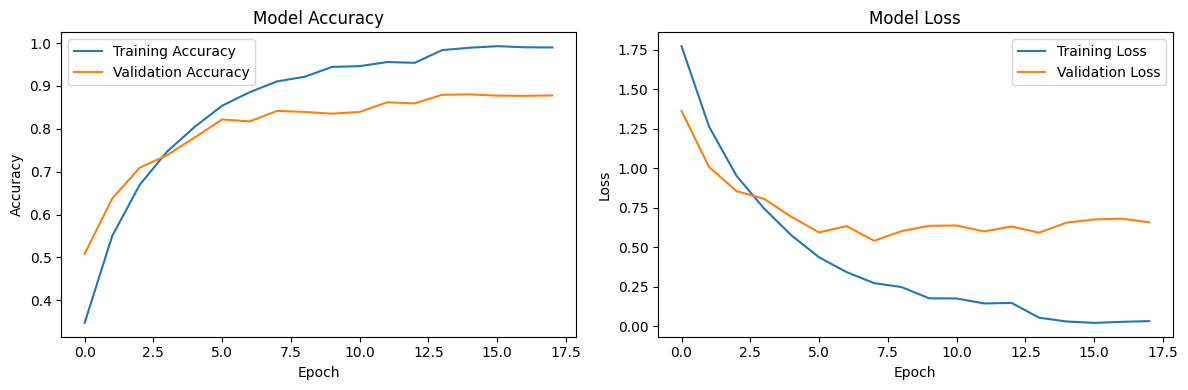

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8352 - loss: 0.5419
Test Accuracy: 84.18%
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


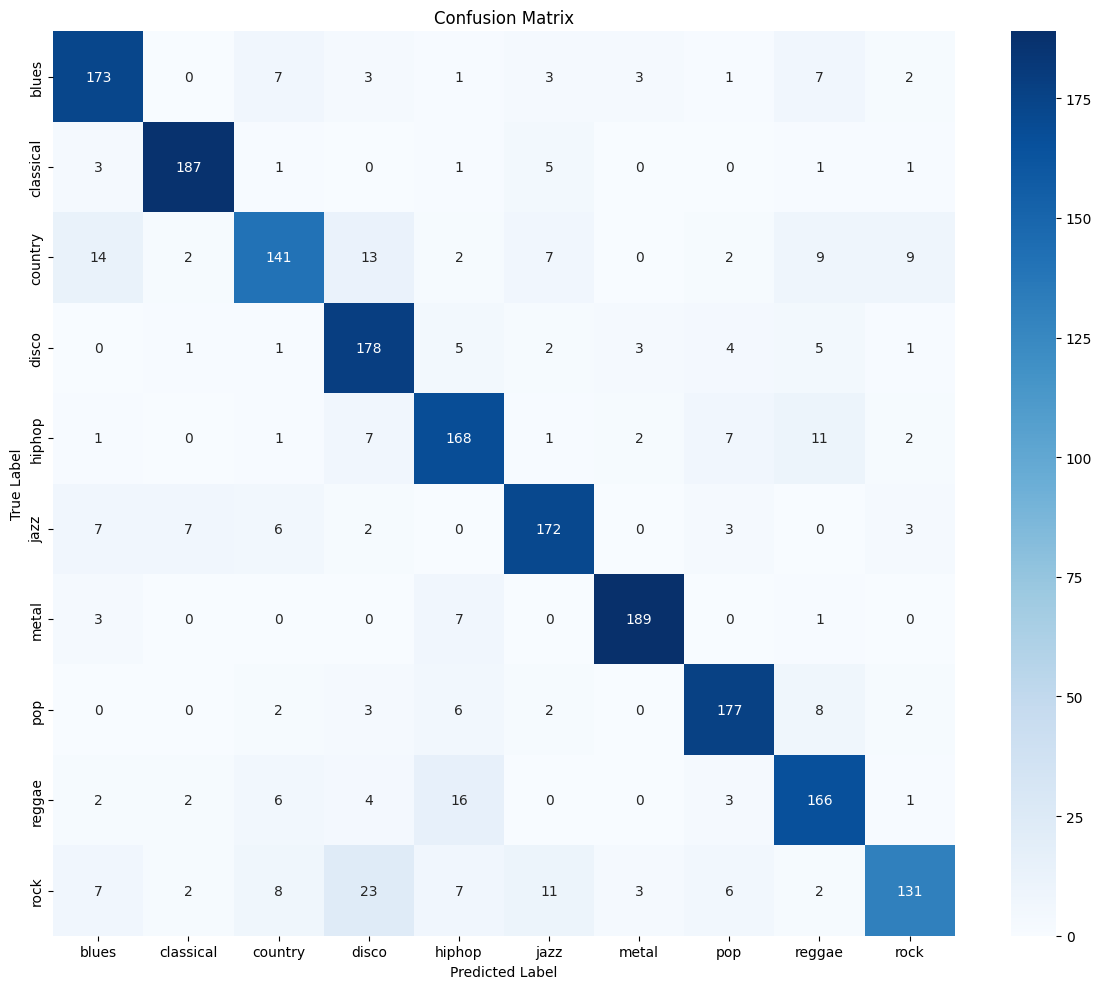

In [8]:
# Define a Res-Gated CNN Block with dynamic pooling
def RGLU_Block(x, filters, kernel_size=3, stride=1, pool_size=2):
    # First Conv1D with RGLU activation
    conv = Conv1D(filters * 2, kernel_size, padding='same')(x)

    # RGLU operation (split into two parts, multiply one by sigmoid of the other)
    # Fix the splitting operation
    split_dim = conv.shape[-1] // 2
    linear = Lambda(lambda x: x[..., :split_dim])(conv)
    gate = Lambda(lambda x: x[..., split_dim:])(conv)
    gate = Activation('sigmoid')(gate)
    gated_output = Multiply()([linear, gate])

    # Residual connection
    if x.shape[-1] == filters:
        residual = x
    else:
        # If dimensions don't match, project input to match output dimensions
        residual = Conv1D(filters, 1, padding='same')(x)

    # Add residual connection
    output = Add()([gated_output, residual])

    # Only apply MaxPooling if the sequence length is greater than the pool size
    # Otherwise just return the output as is
    current_length = output.shape[1]
    if current_length > pool_size:
        pooled = MaxPooling1D(pool_size=pool_size)(output)
    else:
        # If sequence is too short, skip pooling
        pooled = output

    return pooled


# Modified create_res_gated_cnn_model function
def create_res_gated_cnn_model(input_shape, num_classes):
    # Input
    inputs = Input(shape=input_shape)  # Dynamically adjust input shape

    # Initial Conv1D layer
    x = Conv1D(filters=64, kernel_size=3, strides=1, padding='same')(inputs)

    # Track current sequence length to avoid over-pooling
    current_length = input_shape[0]
    print(f"Initial sequence length: {current_length}")

    # RGLU Blocks - Modified to prevent over-pooling
    # Use fewer blocks or adjust pool_size based on input length
    filter_sizes = [64, 128]  # Reduced from [64, 128, 128, 256, 256]

    for filters in filter_sizes:
        x = RGLU_Block(x, filters=filters, kernel_size=3, stride=1, pool_size=2)
        current_length = current_length // 2 if current_length > 2 else current_length
        print(f"After RGLU block with {filters} filters: length = {current_length}")

        # Only add second block if we have enough length
        if current_length > 2:
            x = RGLU_Block(x, filters=filters, kernel_size=3, stride=1, pool_size=2)
            current_length = current_length // 2 if current_length > 2 else current_length
            print(f"After second RGLU block with {filters} filters: length = {current_length}")

    # Skip positional encoding and attention for small sequences
    if current_length >= 4:
        try:
            # Positional Encoding
            positions = tf.range(start=0, limit=current_length, delta=1.0)
            positions = tf.expand_dims(positions, axis=0)
            position_embedding = tf.keras.layers.Embedding(
                input_dim=current_length, output_dim=x.shape[-1]
            )(positions)
            x = Add()([x, position_embedding])

            # Multi-Head Attention - adjust num_heads if needed
            num_heads = min(8, current_length // 2) if current_length >= 2 else 1
            attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=32)(x, x, x)
            x = Add()([x, attention_output])
            print(f"Applied attention with {num_heads} heads")
        except Exception as e:
            print(f"Warning: Skipping attention layers due to: {e}")
    else:
        print("Skipping attention layers due to small sequence length")

    # Decoder - Pooling operations
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)

    # Concatenate pooling outputs
    concat = Concatenate()([avg_pool, max_pool])

    # Fully connected layers
    x = Dense(200, activation='relu')(concat)
    x = Dropout(0.3)(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create and compile model
    model = Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


# Define the model
input_shape = (X_train.shape[1], X_train.shape[2])  # Dynamically set input shape
num_classes = len(np.unique(y_train))  # Number of classes
model = create_res_gated_cnn_model(input_shape, num_classes)

# Model summary
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ]
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Make predictions on the test set
y_pred = np.argmax(model.predict(X_test), axis=1)

# Convert encoded labels back to genre names
y_test_genres = label_encoder.inverse_transform(y_test)
y_pred_genres = label_encoder.inverse_transform(y_pred)

# Create a confusion matrix
cm = tf.math.confusion_matrix(y_test, y_pred).numpy()
classes = label_encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [9]:
# Predict for a single sample
# Select a sample from the test set
sample_num = 10
sample = X_test[sample_num].reshape(1, 55, 1)  # Reshape for prediction

# Predict the genre
prediction = np.argmax(model.predict(sample))
predicted_genre = label_encoder.inverse_transform([prediction])

# Print the result
print(f"Predicted Genre: {predicted_genre[0]}")
print(f"Actual Genre: {label_encoder.inverse_transform([y_test[sample_num]])}")

# Display classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=classes))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
Predicted Genre: pop
Actual Genre: ['pop']

Classification Report:
              precision    recall  f1-score   support

       blues       0.82      0.86      0.84       200
   classical       0.93      0.94      0.94       199
     country       0.82      0.71      0.76       199
       disco       0.76      0.89      0.82       200
      hiphop       0.79      0.84      0.81       200
        jazz       0.85      0.86      0.85       200
       metal       0.94      0.94      0.94       200
         pop       0.87      0.89      0.88       200
      reggae       0.79      0.83      0.81       200
        rock       0.86      0.66      0.74       200

    accuracy                           0.84      1998
   macro avg       0.84      0.84      0.84      1998
weighted avg       0.84      0.84      0.84      1998

